In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from galaxy_generator import simulate_perfect_galaxy, add_source_to_image, sky_noise
from asymmetry import _asymmetry_center, _sky_properties, _asymmetry_func, fourier_deconvolve, get_asymmetry
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from tqdm.notebook import tqdm
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats
from skimage.transform import rescale
import pandas as pd

In [2]:
# Physical properties
mag = 15.5
r = 7
q = 0.5
n = 3
n_clumps = 50

# Image properties
fov = 7 # In terms of reff

# Detector properties
pxscale = 0.1#0.396

# Generate clumps
rs = np.random.random(n_clumps)*(0.8-0.05)+0.05
fs = np.random.random(n_clumps)*(0-0.05) + 0.05

smin = 0.2
smax = 3
sigs = np.random.random(n_clumps)*(smax-smin) + smin
thetas = np.random.random(n_clumps)*360

fs = np.power(10, fs)

clump_properties = {
    'r' : rs,
    'theta' : thetas,
    'flux' : fs,
    'sigma' : sigs
}

In [143]:
def make_galaxy(pxscale):
    perfect_img, params, rpet = simulate_perfect_galaxy(mag, r, pxscale, fov, n, q, 0, n_clumps, clump_properties)
    return perfect_img, rpet

In [144]:
def get_a_values(img, rpet, mask):
    
    ap_size = 1.5*rpet
    
    # Non-fourier asymmetries
    a_sq = get_asymmetry(img, ap_size, mask, a_type='squared', sky_type='annulus', bg_corr='residual', sky_annulus=[3, 4])
    a_cas = get_asymmetry(img, ap_size, mask, a_type='cas', sky_type='annulus', bg_corr='residual', sky_annulus=[3, 4])
    
    # Return all measurements
    res = {'a_cas' : a_cas[0], 'a_sq' : a_sq[0]}
    return res

In [145]:
def run_test(pxscale):
    img, rpet = make_galaxy(pxscale)
    res = get_a_values(img, rpet, np.zeros_like(img))
    return res, img

In [146]:
res_arr = []
imgs = []

pxscales = np.linspace(0.1, 3, 21)
for pxscale in tqdm(pxscales):
    res, img = run_test(pxscale)
    print(np.sum(img**2)*pxscale**2)
    res_arr.append(res)
    imgs.append(img)
    
res_arr = pd.DataFrame(res_arr)

  0%|          | 0/21 [00:00<?, ?it/s]

76030991.36000001
2676706407.424
16866858737.664001
55930697884.87678
138980970096.23038
274145078845.43997
509398518225.3055
834862019044.9664
1320936418993.7666
1911409150364.877
2652038939279.3604
3769715471745.0244
5097654722127.461
6546713784723.046
8685367092471.397
11161256134246.398
13583728960444.826
17466952013217.793
21249391855429.223
26327945005858.816
33039416033280.0


Text(0, 0.5, '$A^2$')

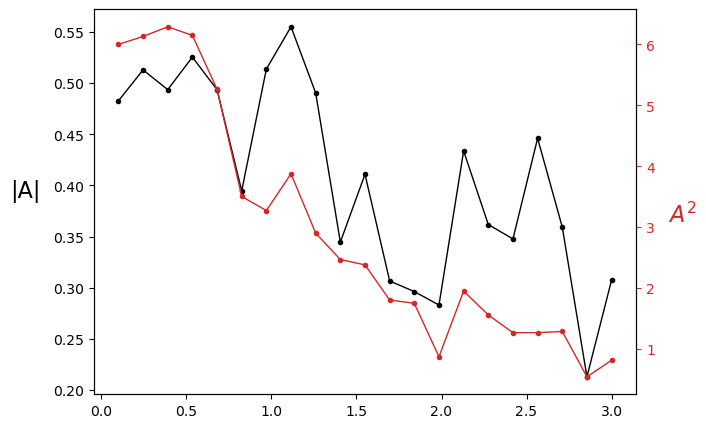

In [147]:
fig = plt.figure(figsize=(7,5))

ax = plt.axes()
ax.plot(pxscales, res_arr.a_cas, '.-', lw=1, color='k', label=r'$A^2$')
ax.tick_params('y', left=True, labelleft=True, right=False, labelright=False, color='k')
ax.set_ylabel(r'|A|', color='k', size=16, rotation=0, labelpad=20)

ax2 = plt.twinx()
ax2.plot(pxscales, res_arr.a_sq, '.-', lw=1, color='C3', label='|A|')
ax2.tick_params('y', right=True, labelright=True, left=False, labelleft=False, color='C3', labelcolor='C3')
ax2.set_ylabel(r'$A^2$', color='C3', size=16, rotation=0, labelpad=20)

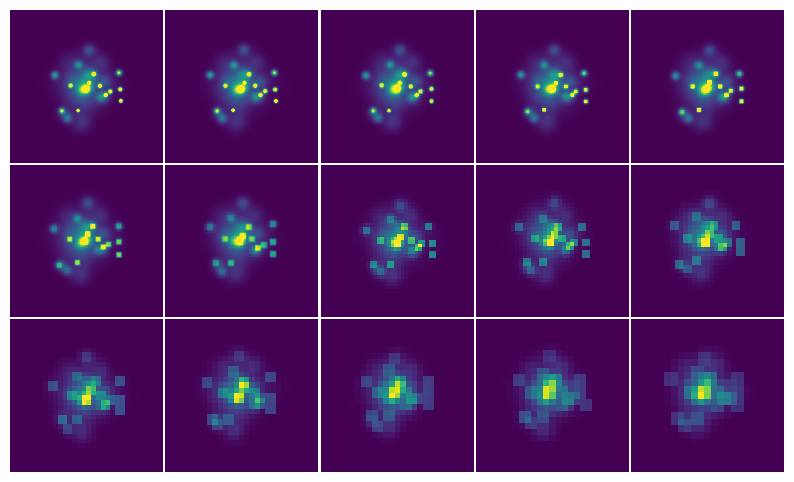

In [148]:
fig, axs = plt.subplots(3,5, figsize=(10,6))

axs = axs.flatten()

for ax, img, pxscale in zip(axs, imgs, pxscales):
    ax.imshow((img/pxscale**2), vmin=0, vmax=1e5)
    
for ax in axs:
    ax.axis('off')
    
plt.subplots_adjust(wspace=0.01, hspace=0.01)